# Solution for the second science case

In [ ]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

#########################################
# Adapted for XI LAPIS 2025
# by Felipe Almeida-Fernandes
# E-mail: felipe.fernandes@inpe.br
#########################################

## SETUP

We may need to install a few packages (lsdb, splusdata, dask):

In [ ]:
# LSDB
!pip install lsdb

# splusdata
!pip install splusdata

# dask
!pip install dask


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client


# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt


### Start Dask client

In [ ]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 8
max_mem = '6GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

<Client: 'tcp://127.0.0.1:63803' processes=8 threads=8, memory=44.70 GiB>

## S-PLUS Catalogs choice

In this case we will be using the aperture photometry catalog named "dual". Learn more about this catalog at https://splus.cloud/documentation/DR4?Photometry

In [ ]:
# search for the full S-PLUS DR4/dual mode catalog
dr4dual_search = splusdata.get_hipscats('dr4/dual')

# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')

# select the first catalog found
dr4dual_hipscat, dr4dual_margin_cache_hipscat = dr4dual_search[0]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/dual/', 'https://splus.cloud/HIPS/catalogs/dr4/dual_2arcsec/']]


### Value added catalog

In this activity we will also be using the Value Added Catalog that offers Star/galaxy/quasar classification.

Learn more about this catalog at https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification

In [ ]:
# Search for the DR4 Star Galaxy Quasar VAC
dr4sqg_search = splusdata.get_hipscats('dr4/sqg')

# Print all catalogs found with the pattern above
print(f'dr4/sqg search: {dr4sqg_search}')

# select the first catalog found
dr4sqg_hipscat, dr4sqg_margin_cache_hipscat = dr4sqg_search[0]

dr4/sqg search: [['https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg/', 'https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg_2arcsec/']]


### Selecting the columns

In this case, we will use the magnitudes from 'auto' aperture mode. The size of this aperture adapts according to the radial profile of the extended source (based on the Kron radius).

Read mode at https://splus.cloud/documentation/DR4?Photometry

We are also applying more filters to the data (for all filters):

1) Signal-to-noise > 5
2) Signal-to-noise != 99 (remove non-detected sources)
3) 14 < magnitude < 22 (in each filter)

In [ ]:
# Create the columns list to retrieve only necessaries columns

columns = ['ID', 'Field', 'RA', 'DEC', 'A', 'B', 'ISOarea', 'MU_MAX_INST', 'CLASS_STAR']
apperture = 'auto'
bands = ['u', 'g', 'r', 'z' ,'J0660']
columns += [f'{b}_{apperture}' for b in bands]
columns += [f's2n_{b}_{apperture}' for b in bands]

# filters
SN_min = 5
filters = [(f's2n_{b}_{apperture}', '>', SN_min) for b in bands]
filters += [(f's2n_{b}_{apperture}', '!=', 99) for b in bands]
filters += [(f'{b}_{apperture}', '>', 14) for b in bands]
filters += [(f'{b}_{apperture}', '<', 20) for b in bands]
filters += [('CLASS_STAR', '<', 0.1)]
filters += [('A', '>', 0), ('ISOarea', '>', 0), ('MU_MAX_INST', '>', 0)]

## Read and crossmatch catalogs using LSDB

Note we are applying a filter `PROB_GAL` > 0.98, to select only sources classified as galaxies

### Read S-PLUS DR4 (aperture photometry catalog -- dual mode)

In [ ]:
# Read DR4 dual HiPSCAT
dr4dual = lsdb.read_hats(dr4dual_hipscat[:-1],
                            margin_cache=dr4dual_margin_cache_hipscat[:-1],
                            columns=columns,
                            filters=filters)


## Now we will do a box search around the Fornax cluster

Box searchers are similar to cone searches, but in this case we specify the extremes of a box in RA and DEC

LSDB also handles polygon searches (you can read more here: https://docs.lsdb.io/en/stable/tutorials/filtering_large_catalogs.html)

In [ ]:
# Let's get the resultant table using a cone search:
fornax_ra = [50,60]
fornax_dec = [-38, -32]

search_radius = 10 # arcsec

objects_table_boxsearch = dr4dual.box_search(ra=fornax_ra, dec=fornax_dec)
objects_table = objects_table_boxsearch.compute()

objects_table

ID         Field         RA  \
_healpix_29                                                                
2422629532624606538  DR4_3_SPLUS-s29s36_0006359  SPLUS-s29s36  59.892557   
2422630019701387851  DR4_3_SPLUS-s29s36_0007279  SPLUS-s29s36  59.992035   
...                                         ...           ...        ...   
2527716313034293994  DR4_3_SPLUS-s25s35_0033662  SPLUS-s25s35  54.106516   
2527716353251597982  DR4_3_SPLUS-s25s35_0033142  SPLUS-s25s35  54.077307   

                           DEC         A         B   ISOarea  MU_MAX_INST  \
_healpix_29                                                                 
2422629532624606538 -37.992511  0.000331  0.000254  0.000001    18.017248   
2422630019701387851  -37.96657  0.000935  0.000431  0.000006    16.694468   
...                        ...       ...       ...       ...          ...   
2527716313034293994 -32.010492  0.000673   0.00037  0.000004    16.551226   
2527716353251597982 -32.015454  0.000793  0.000671  0.000009    16.594439   

                     CLASS_STAR     u_auto     g_auto     r_auto     z_auto  \
_healpix_29                                                                   
2422629532624606538    0.036651  19.922981  19.453451  19.115761  18.931114   
2422630019701387851    0.031136   19.55809  17.964136  17.183704  16.521805   
...                         ...        ...        ...        ...        ...   
2527716313034293994    0.028119  19.738834  18.282787  17.479473  16.748125   
2527716353251597982    0.026165  17.750652  17.410275  16.744429  16.172092   

                     J0660_auto  s2n_u_auto  s2n_g_auto  s2n_r_auto  \
_healpix_29                                                           
2422629532624606538   19.051638   11.666958    21.67034   28.556368   
2422630019701387851   17.086914    7.119964   36.885223   71.536575   
...                         ...         ...         ...         ...   
2527716313034293994   17.306738    5.597859   28.815807   61.428333   
2527716353251597982   16.657604   27.936361     50.7798   95.553322   

                     s2n_z_auto  s2n_J0660_auto  
_healpix_29                                      
2422629532624606538   10.858811        26.52256  
2422630019701387851   42.238865       68.222733  
...                         ...             ...  
2527716313034293994   48.435749       68.497627  
2527716353251597982   65.821548       98.348389  

[5115 rows x 19 columns]

In [ ]:
# Selecting interesting galaxies to visualize

# Select long extended sources
gal_filter = objects_table["A"] >= 5 / 3600 # Size in degrees
gal_filter = objects_table["B"] / objects_table["A"] < 0.95

gal_filter = objects_table["CLASS_STAR"] < 0.1
gal_filter = objects_table["MU_MAX_INST"]/objects_table["r_auto"] > 1
gal_filter = objects_table["r_auto"] < 17

gal_objects_table = objects_table[gal_filter]
gal_objects_table

ID         Field         RA  \
_healpix_29                                                                
2422632141886461915  DR4_3_SPLUS-s29s36_0010134  SPLUS-s29s36   59.95062   
2426806312300748045  DR4_3_SPLUS-s29s31_0006498  SPLUS-s29s31  51.359278   
...                                         ...           ...        ...   
2527693718922918602  DR4_3_SPLUS-s25s34_0029525  SPLUS-s25s34  53.071921   
2527716353251597982  DR4_3_SPLUS-s25s35_0033142  SPLUS-s25s35  54.077307   

                           DEC         A         B   ISOarea  MU_MAX_INST  \
_healpix_29                                                                 
2422632141886461915 -37.876604  0.001321  0.000557   0.00001    17.228802   
2426806312300748045 -37.984824  0.000659  0.000538  0.000006    16.425621   
...                        ...       ...       ...       ...          ...   
2527693718922918602 -32.063839  0.000887  0.000775   0.00001    17.112976   
2527716353251597982 -32.015454  0.000793  0.000671  0.000009    16.594439   

                     CLASS_STAR     u_auto     g_auto     r_auto     z_auto  \
_healpix_29                                                                   
2422632141886461915     0.01457  18.346729  17.334167  16.776865  16.357273   
2426806312300748045    0.027679  18.309753  17.349562  16.804863  16.407412   
...                         ...        ...        ...        ...        ...   
2527693718922918602     0.01344  18.135874  17.065529  16.710781  16.275642   
2527716353251597982    0.026165  17.750652  17.410275  16.744429  16.172092   

                     J0660_auto  s2n_u_auto  s2n_g_auto  s2n_r_auto  \
_healpix_29                                                           
2422632141886461915   16.679729   14.238846   43.968475   70.679649   
2426806312300748045   16.791832   15.287068   41.234867   78.012634   
...                         ...         ...         ...         ...   
2527693718922918602   16.657906   21.289438   58.696629   68.343445   
2527716353251597982   16.657604   27.936361     50.7798   95.553322   

                     s2n_z_auto  s2n_J0660_auto  
_healpix_29                                      
2422632141886461915    32.72427       67.745995  
2426806312300748045   55.986958       68.185509  
...                         ...             ...  
2527693718922918602   33.651688       77.271988  
2527716353251597982   65.821548       98.348389  

[1763 rows x 19 columns]

## Plotting the color-magnitude diagram

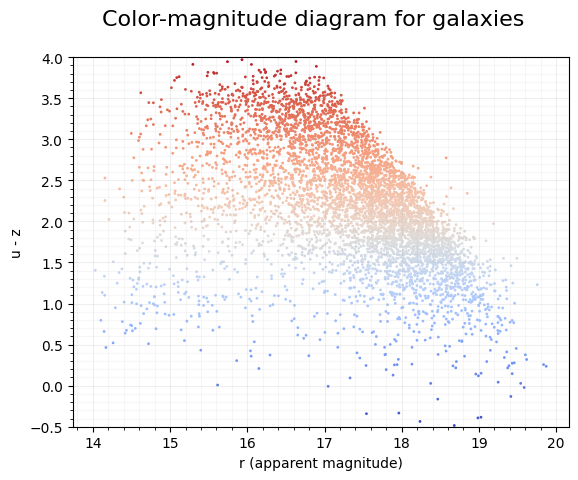

In [ ]:
def plot_color_magnitude_diagram(ax):

    color_u_z = objects_table['u_auto'] - objects_table['z_auto']
    mag_r = objects_table['r_auto']

    ax.scatter(mag_r, color_u_z, s = 1, c = color_u_z, cmap='coolwarm', vmin=-0.5, vmax=4)

    #####################
    # Formating the plots

    ax.set_ylim((-0.5, 4))

    ax.minorticks_on()
    ax.grid(which = 'major', alpha = 0.2)
    ax.grid(which = 'minor', alpha = 0.1)

    ax.set_ylabel("u - z")
    ax.set_xlabel("r (apparent magnitude)")

fig, ax = plt.subplots()
fig.suptitle("Color-magnitude diagram for galaxies", fontsize = 16)

plot_color_magnitude_diagram(ax)

## Generating images using splusdate

In [ ]:
conn = splusdata.Core()

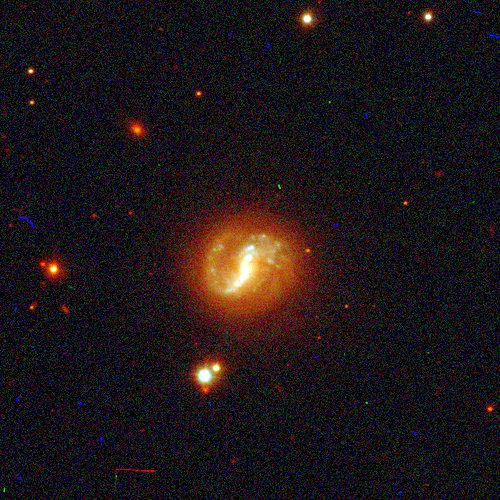

In [ ]:

conn.trilogy_image(51.99239, -37.14656, 500, "R, I, Z", "G, F660", "U, F430, F410")


## Can be skipped: Saving images of all selected sources

(just so we can choose the best looking ones)

In [ ]:
import os

if not os.path.exists("gal_images"):
    os.mkdir("gal_images")

In [ ]:
# Save images of all selected objects

RAs = list(gal_objects_table["RA"])
DEs = list(gal_objects_table["DEC"])

for i in range(len(gal_objects_table)):
    RAi = RAs[i]
    DECi = DEs[i]

    try:
        imgi = conn.trilogy_image(RAi, DECi, 500, "R, I, Z", "G, F660", "U, F430, F410")
        plt.imshow(imgi)
        plt.savefig(f"gal_images/{i}_{RAi:.5f}_{DECi:.5f}.png")
    except:
        pass


## Visualizing different galaxies in S-PLUS

In [ ]:
def plot_img_and_cmd_for_entry(table_id):
    fig, axs = plt.subplots(1,2, figsize = (11, 5))

    RA = gal_objects_table.iloc[table_id]["RA"]
    DEC = gal_objects_table.iloc[table_id]["DEC"]

    fig.suptitle(f"RA = {RA:.5f}, DEC = {DEC:.5f}")
    img = conn.trilogy_image(RA, DEC, 500, "Z", "G", "U")
    axs[0].imshow(img)

    # Plot the color - magnitude diagram
    galaxy_mag_r = gal_objects_table.iloc[table_id]["r_auto"]
    galaxy_color_u_z = gal_objects_table.iloc[table_id]["u_auto"] - gal_objects_table.iloc[table_id]["z_auto"]

    plot_color_magnitude_diagram(axs[1])
    axs[1].scatter(galaxy_mag_r, galaxy_color_u_z, s = 100, color = "#000", marker = "x")

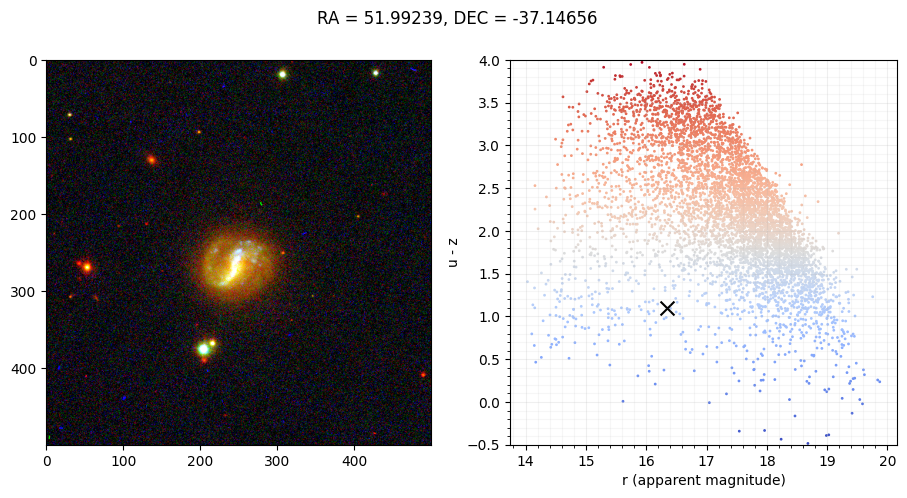

In [ ]:
# Choose the entry
table_id = 32

plot_img_and_cmd_for_entry(table_id)


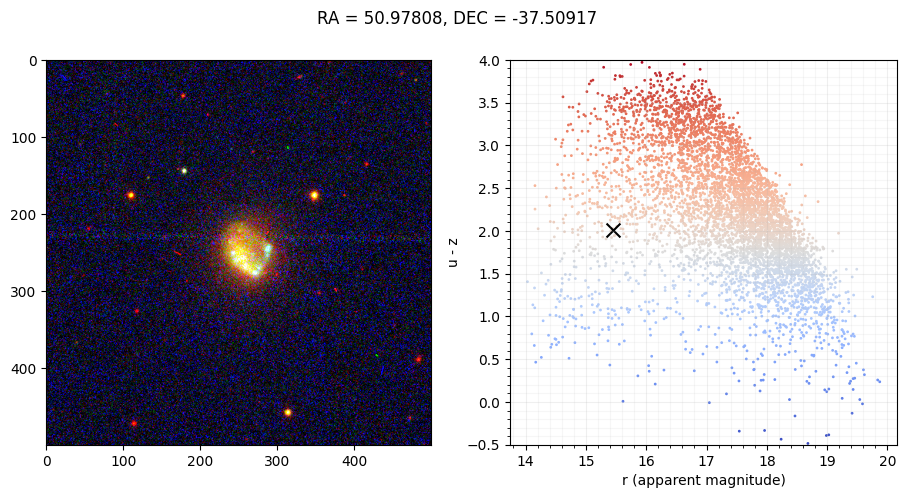

In [ ]:
# Choose the entry
table_id = 43

plot_img_and_cmd_for_entry(table_id)


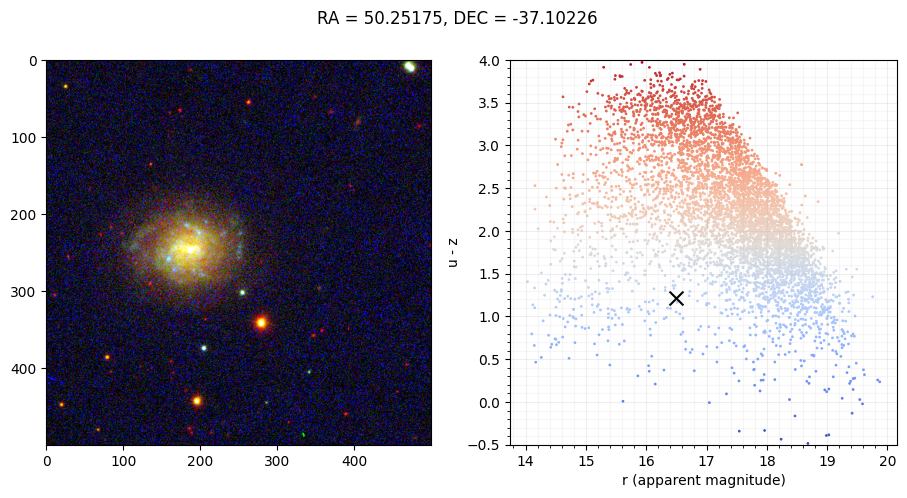

In [ ]:
# Choose the entry
table_id = 73

plot_img_and_cmd_for_entry(table_id)


###  Spatial distribution plot

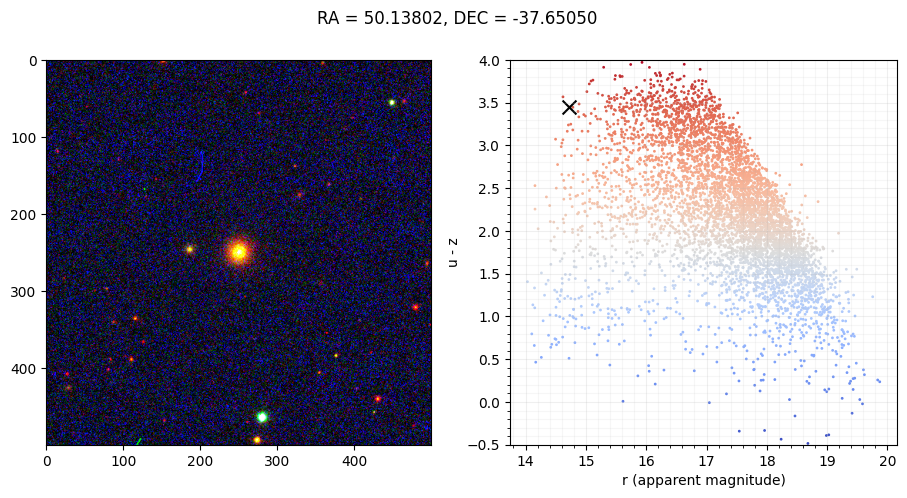

In [ ]:
# Choose the entry
table_id = 65

plot_img_and_cmd_for_entry(table_id)


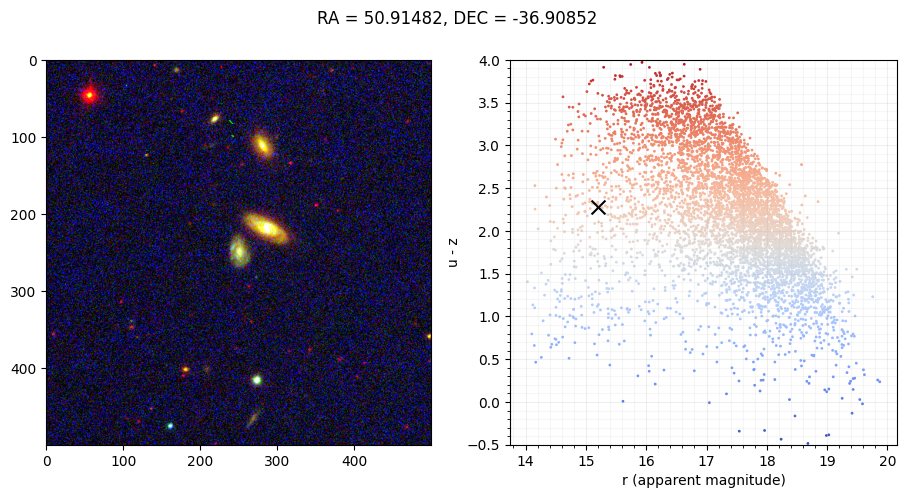

In [ ]:
# Choose the entry
table_id = 51

plot_img_and_cmd_for_entry(table_id)


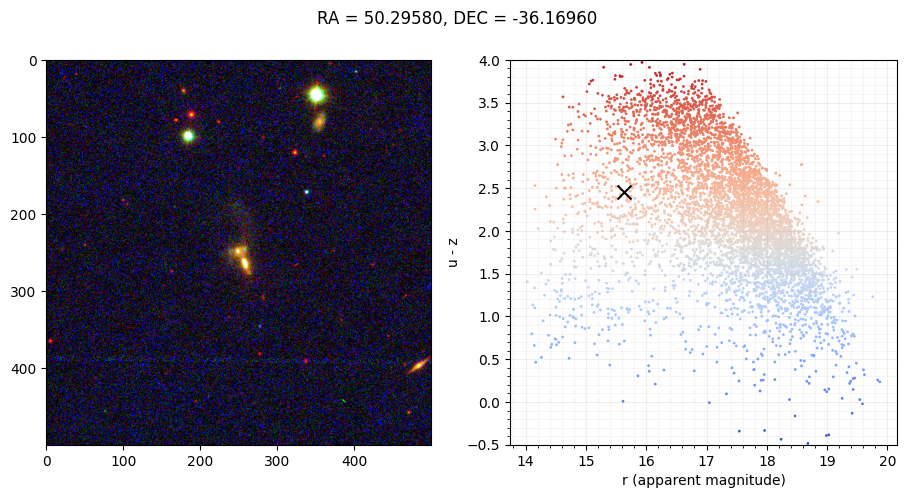

In [ ]:
# Choose the entry
table_id = 96

plot_img_and_cmd_for_entry(table_id)


## Visualizing the importance of the H-alpha filter

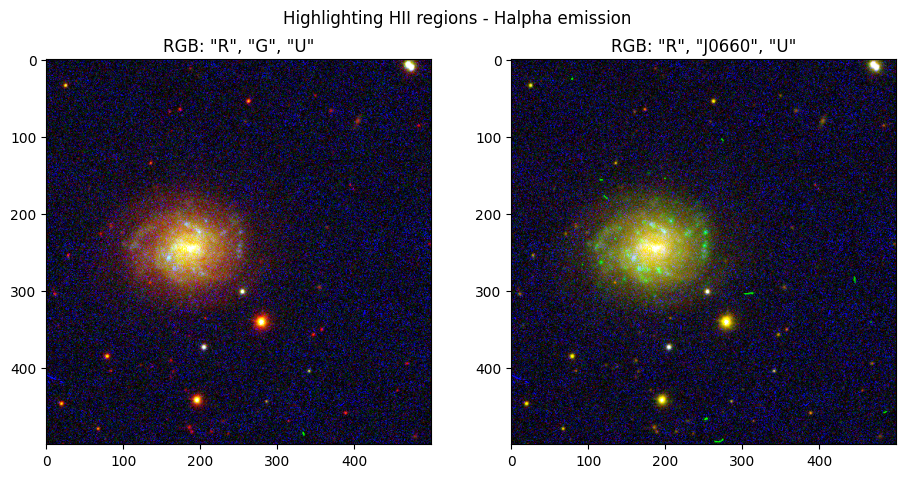

In [ ]:
# Choose the entry
table_index = 73

################
# Plot the images

fig, axs = plt.subplots(1,2, figsize = (11, 5))

RA = gal_objects_table.iloc[table_index]["RA"]
DEC = gal_objects_table.iloc[table_index]["DEC"]

fig.suptitle(f"Highlighting HII regions - Halpha emission")
img = conn.trilogy_image(RA, DEC, 500, "I", "G", "U")
axs[0].imshow(img)
axs[0].set_title('RGB: "R", "G", "U"')

img = conn.trilogy_image(RA, DEC, 500, "I", "F660", "U")
axs[1].set_title('RGB: "R", "J0660", "U"')
axs[1].imshow(img)

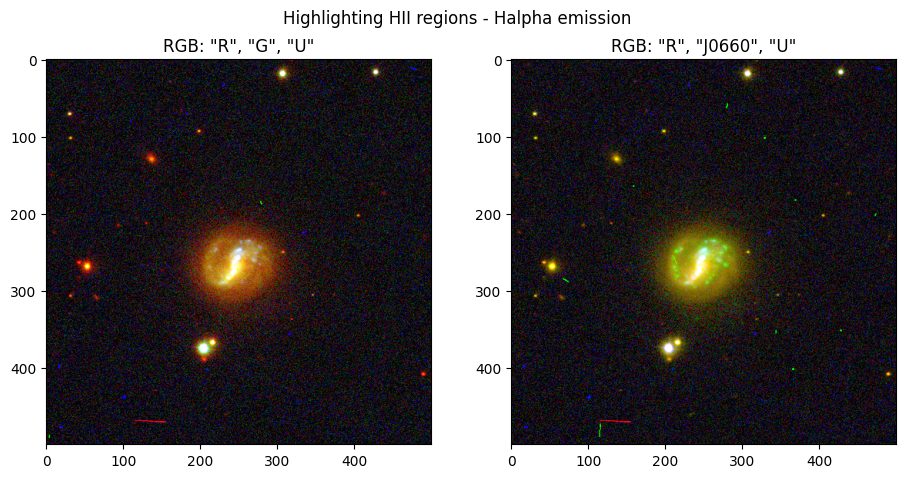

In [ ]:
# Choose the entry
table_index = 32

################
# Plot the image

fig, axs = plt.subplots(1,2, figsize = (11, 5))

RA = gal_objects_table.iloc[table_index]["RA"]
DEC = gal_objects_table.iloc[table_index]["DEC"]

fig.suptitle(f"Highlighting HII regions - Halpha emission")
img = conn.trilogy_image(RA, DEC, 500, "I", "G", "U")
axs[0].imshow(img)
axs[0].set_title('RGB: "R", "G", "U"')

img = conn.trilogy_image(RA, DEC, 500, "I", "F660", "U")
axs[1].set_title('RGB: "R", "J0660", "U"')
axs[1].imshow(img)